In [1]:
!pip install nltk

In [2]:
import os
import requests
import pandas as pd
import nltk
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
uploaded_files = [f for f in os.listdir("/content/") if f.endswith(".tar.gz")]
print("Uploaded Corpus Files:", uploaded_files)

Uploaded Corpus Files: ['eng_news_2024_300K.tar.gz']


In [5]:
import tarfile

In [6]:
#Extraction directory in my drive
extracted_dir = "/content/extracted_corpus"
os.makedirs(extracted_dir, exist_ok=True)

In [8]:
if uploaded_files:
    dataset_path = os.path.join("/content/", uploaded_files[0])  # Use the uploaded tar.gz file
    print(f"Extracting {dataset_path} ...")
    with tarfile.open(dataset_path, "r:gz") as tar:
        tar.extractall(path=extracted_dir)
    print("Extraction complete!")
else:
    print("No .tar.gz file found!")

Extracting /content/eng_news_2024_300K.tar.gz ...
Extraction complete!


In [ ]:
#Used to check how the file is stored in the drive
for root, dirs, files in os.walk(extracted_dir):
    print(f"In folder: {root}")
    for file in files:
        print(f"  - {file}")

In folder: /content/extracted_corpus
In folder: /content/extracted_corpus/eng_news_2024_300K
  - eng_news_2024_300K-sources.txt
  - eng_news_2024_300K-meta.txt
  - eng_news_2024_300K-inv_so.txt
  - eng_news_2024_300K-words.txt
  - eng_news_2024_300K-co_n.txt
  - eng_news_2024_300K-inv_w.txt
  - eng_news_2024_300K-import.sql
  - eng_news_2024_300K-sentences.txt
  - eng_news_2024_300K-co_s.txt


In [9]:
#For getting all the text files
text_files = []
#text_files = [os.path.join(extracted_dir, f) for f in os.listdir(extracted_dir) if f.endswith(".txt")]
#didn't use the above code as the txt files are inside a folder inside the tar.gz file
for root, dirs, files in os.walk(extracted_dir):
    for file in files:
        if file.endswith(".txt"):
            text_files.append(os.path.join(root, file))
print("Extracted Corpus Files:", text_files)

Extracted Corpus Files: ['/content/extracted_corpus/eng_news_2024_300K/eng_news_2024_300K-sources.txt', '/content/extracted_corpus/eng_news_2024_300K/eng_news_2024_300K-meta.txt', '/content/extracted_corpus/eng_news_2024_300K/eng_news_2024_300K-inv_so.txt', '/content/extracted_corpus/eng_news_2024_300K/eng_news_2024_300K-words.txt', '/content/extracted_corpus/eng_news_2024_300K/eng_news_2024_300K-co_n.txt', '/content/extracted_corpus/eng_news_2024_300K/eng_news_2024_300K-inv_w.txt', '/content/extracted_corpus/eng_news_2024_300K/eng_news_2024_300K-sentences.txt', '/content/extracted_corpus/eng_news_2024_300K/eng_news_2024_300K-co_s.txt']


In [10]:
stop_words = set(stopwords.words('english'))

In [11]:
def preprocess_text(file_path):
  #Used to pre-process the text file
  processed_sentences=[]
  with open(file_path, 'r', encoding='utf-8') as file:
    for line in file:
      #First, we will remove the meta data
      line = re.sub(r'^\d+\t','',line.strip())
      #Nxt, to lower case
      line=line.lower()
      #Remove punctuations
      line=line.translate(str.maketrans('','',string.punctuation))
      #Tokenization
      tokens=word_tokenize(line)
      #Remove stop words
      filtered_tokens=[word for word in tokens if word not in stop_words]

      processed_sentence=' '.join(filtered_tokens)
      processed_sentences.append(processed_sentence)
  return processed_sentences

In [12]:
all_sentences=[]
for file in text_files:
  sentences=preprocess_text(file)
  all_sentences.extend(preprocess_text(file))

print(f"Total processed sentences: {len(all_sentences)}")

Total processed sentences: 10059085


In [13]:
#saving this file for future works
processed_file = "/content/processed_corpus.txt"
with open(processed_file, "w", encoding="utf-8") as f:
    for sentence in all_sentences:
        f.write(sentence + "\n")

print(f"Processed corpus saved at: {processed_file}")

Processed corpus saved at: /content/processed_corpus.txt


# **Co-occurrence Matrix**

In [14]:
tokenized_sentences=[sentence.split() for sentence in all_sentences]

In [15]:
from collections import Counter, defaultdict
import itertools

In [16]:
#We will build the co-occurence matrix here
def build_cooccurrence_matrix(tokenized_sentences, window_size, vocab_limit):
  word_counts=Counter(itertools.chain(*tokenized_sentences))#Counting of words
  most_common_words=[word for word,_ in word_counts.most_common(vocab_limit)]#Limiting to vocab size

  word_to_index={word:i for i,word in enumerate(most_common_words)}#word to index mapping

  cooccurrence_matrix = defaultdict(Counter) #Initialising the matrix as a dictionary

  for sentence in tokenized_sentences:
    sentence_length=len(sentence)

    for i,target_word in enumerate(sentence):
      if target_word not in word_to_index: #To skip the owrds in the bottom vocab
          continue
      start=max(0,i-window_size)
      end=min(sentence_length,i+window_size+1)#To ensure that we don't go out of bound

      for j in range(start,end):
        if i!=j:#Exclude the target word
          context_word=sentence[j]
          if context_word in word_to_index:
            cooccurrence_matrix[word_to_index[target_word]][word_to_index[context_word]]+=1

  return cooccurrence_matrix,word_to_index


In [ ]:
cooccurrence_matrix, word2idx = build_cooccurrence_matrix(tokenized_sentences, window_size=5, vocab_limit=50000)

In [17]:
import numpy as np
from scipy.sparse import coo_matrix

In [18]:
#Convert to Sparse Matrix
def convert_to_sparse_matrix(cooccurrence_matrix, vocab_size):
    """Converts dictionary-based co-occurrence matrix into a sparse SciPy matrix."""

    row, col, data = [], [], []

    for word_idx, context in cooccurrence_matrix.items():
        for context_idx, count in context.items():
            row.append(word_idx)
            col.append(context_idx)
            data.append(count)

    # Convert to a sparse matrix (COO format)
    return coo_matrix((data, (row, col)), shape=(vocab_size, vocab_size))


In [ ]:
# Convert to sparse format
sparse_cooccurrence_matrix = convert_to_sparse_matrix(cooccurrence_matrix, len(word2idx))

print(f"Sparse matrix created! Shape: {sparse_cooccurrence_matrix.shape}")

Sparse matrix created! Shape: (50000, 50000)


**TO test different window size**

In [ ]:
window_sizes = [2, 4, 5, 7, 10, 12]  # Different window sizes to test
results = {}

for w in window_sizes:
    print(f"🔹 Testing window size: {w}")
    cooccurrence_matrix, word2idx = build_cooccurrence_matrix(tokenized_sentences, window_size=w, vocab_limit=50000)

    # Convert to sparse matrix
    sparse_matrix = convert_to_sparse_matrix(cooccurrence_matrix, len(word2idx))

    # Store results
    results[w] = sparse_matrix
    print(f"Co-occurrence matrix created for window size {w}\n")


🔹 Testing window size: 2
Co-occurrence matrix created for window size 2

🔹 Testing window size: 4
Co-occurrence matrix created for window size 4

🔹 Testing window size: 5
Co-occurrence matrix created for window size 5

🔹 Testing window size: 7
Co-occurrence matrix created for window size 7

🔹 Testing window size: 10
Co-occurrence matrix created for window size 10

🔹 Testing window size: 12
Co-occurrence matrix created for window size 12



In [ ]:
#Now we will compare the word similarities
from scipy.spatial.distance import cosine
import numpy as np

In [ ]:
def get_word_vector(word, sparse_matrix, word2idx):
    """Fetch the word vector from the sparse matrix"""
    idx = word2idx.get(word)
    if idx is None:
        return None
    return sparse_matrix.tocsr()[idx].toarray().flatten()  # Convert sparse row to dense array

In [ ]:
def compare_similarity(word1, word2):
    """Compare similarity for different window sizes"""
    print(f"\n🔍 Similarity between '{word1}' and '{word2}':")

    for w in window_sizes:
        vec1 = get_word_vector(word1, results[w], word2idx)
        vec2 = get_word_vector(word2, results[w], word2idx)

        if vec1 is None or vec2 is None:
            print(f"❌ '{word1}' or '{word2}' not found in vocab (Window size {w})")
            continue

        similarity = 1 - cosine(vec1, vec2)
        print(f"Window size {w}: Cosine Similarity = {similarity:.4f}")

In [ ]:
compare_similarity("king", "queen")
compare_similarity("apple", "banana")
compare_similarity("car", "engine")


🔍 Similarity between 'king' and 'queen':
Window size 2: Cosine Similarity = 0.5780
Window size 4: Cosine Similarity = 0.6847
Window size 5: Cosine Similarity = 0.7101
Window size 7: Cosine Similarity = 0.7475
Window size 10: Cosine Similarity = 0.7739
Window size 12: Cosine Similarity = 0.7820

🔍 Similarity between 'apple' and 'banana':
❌ 'apple' or 'banana' not found in vocab (Window size 2)
❌ 'apple' or 'banana' not found in vocab (Window size 4)
❌ 'apple' or 'banana' not found in vocab (Window size 5)
❌ 'apple' or 'banana' not found in vocab (Window size 7)
❌ 'apple' or 'banana' not found in vocab (Window size 10)
❌ 'apple' or 'banana' not found in vocab (Window size 12)

🔍 Similarity between 'car' and 'engine':
Window size 2: Cosine Similarity = 0.3339
Window size 4: Cosine Similarity = 0.4702
Window size 5: Cosine Similarity = 0.5026
Window size 7: Cosine Similarity = 0.5527
Window size 10: Cosine Similarity = 0.5892
Window size 12: Cosine Similarity = 0.6065


In [ ]:
# we will visualise the clustering Quality, Better the window size, better the clustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

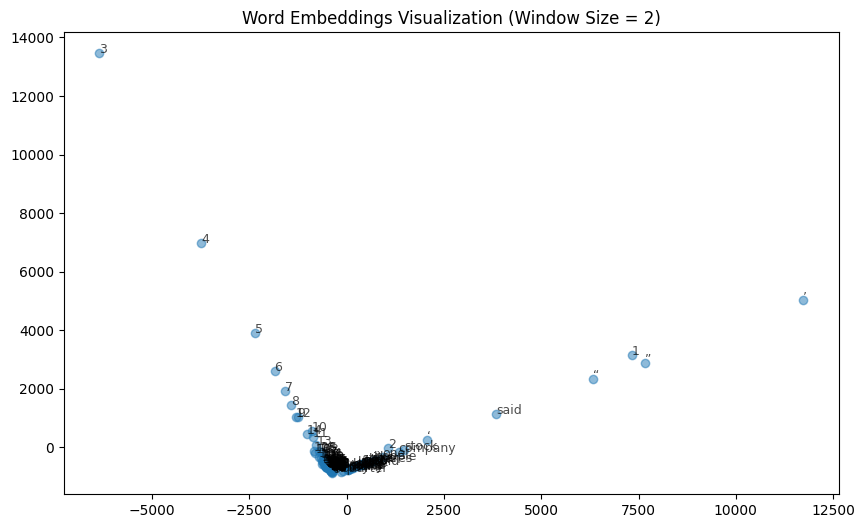

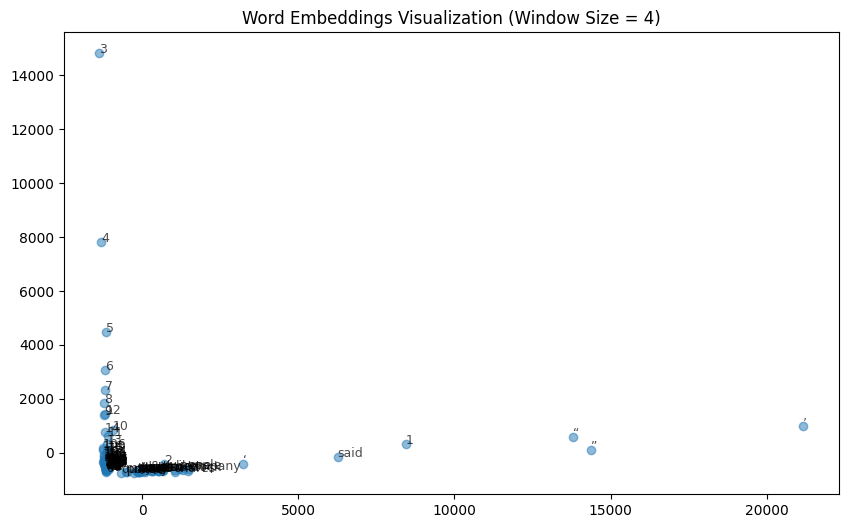

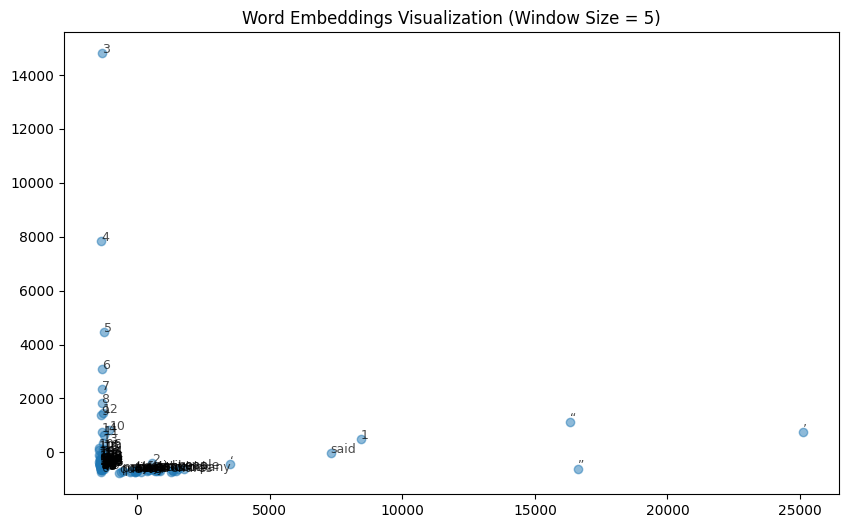

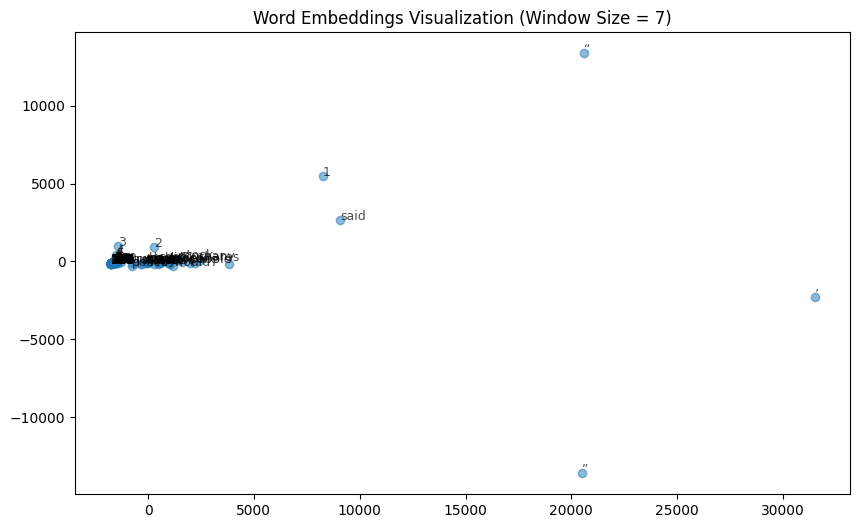

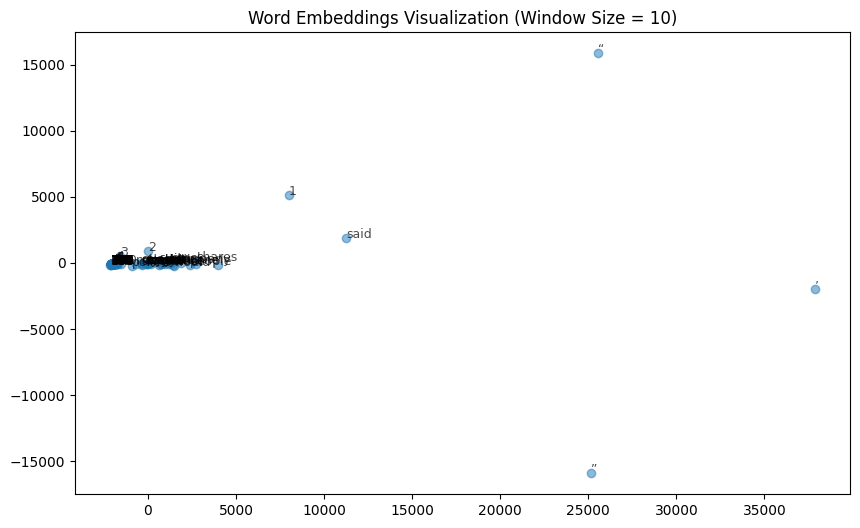

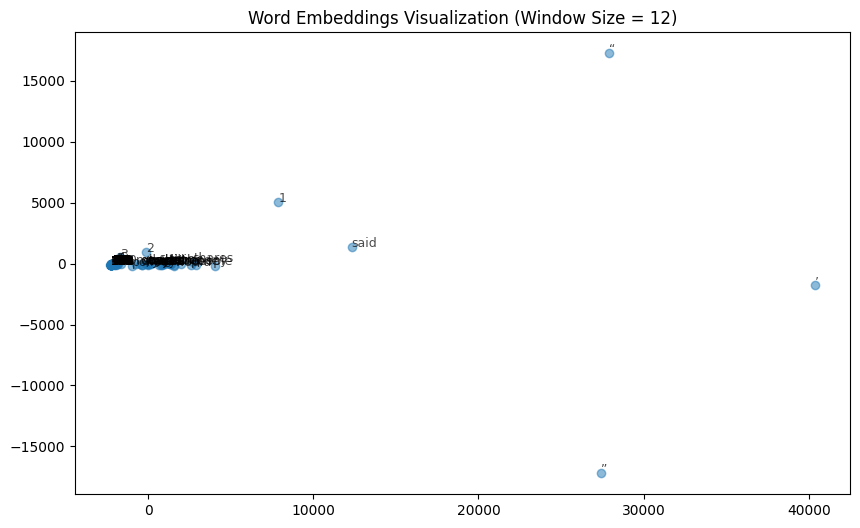

In [ ]:
def visualize_embeddings(window_size):
    """Reduces word vectors to 2D and visualizes using PCA"""
    matrix = results[window_size].toarray()

    # Reduce dimensionality
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(matrix[:100])  # Take top 100 words

    plt.figure(figsize=(10, 6))
    plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.5)

    # Annotate words
    words = list(word2idx.keys())[:100]
    for i, word in enumerate(words):
        plt.annotate(word, (reduced[i, 0], reduced[i, 1]), fontsize=9, alpha=0.7)

    plt.title(f"Word Embeddings Visualization (Window Size = {window_size})")
    plt.show()

for w in window_sizes:
    visualize_embeddings(w)

**So from figure, we can find that the optimum window size is 7**

In [19]:
cooccurrence_matrix, word2idx = build_cooccurrence_matrix(tokenized_sentences, window_size=7, vocab_limit=50000)

# Convert to sparse format
sparse_matrix = convert_to_sparse_matrix(cooccurrence_matrix, len(word2idx))
print(f"Co-occurrence matrix rebuilt with window size 7! Shape: {sparse_matrix.shape}")


Co-occurrence matrix rebuilt with window size 7! Shape: (50000, 50000)


In [ ]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.spatial.distance import cosine

In [ ]:
d_values = [50, 100, 200, 300]
#Store results
embedding_matrices = {}

for d in d_values:
    print(f"🔹 Applying SVD with d = {d}")
    svd = TruncatedSVD(n_components=d)
    word_embeddings = svd.fit_transform(sparse_matrix)

    # Store embeddings
    embedding_matrices[d] = word_embeddings
    print(f"SVD Applied! Shape: {word_embeddings.shape}\n")

🔹 Applying SVD with d = 50
SVD Applied! Shape: (50000, 50)

🔹 Applying SVD with d = 100
SVD Applied! Shape: (50000, 100)

🔹 Applying SVD with d = 200
SVD Applied! Shape: (50000, 200)

🔹 Applying SVD with d = 300
SVD Applied! Shape: (50000, 300)



In [ ]:
def get_word_vector(word, embedding_matrix, word2idx):
    """Fetch the word vector from the matrix"""
    idx = word2idx.get(word)
    if idx is None:
        return None
    return embedding_matrix[idx]


def compare_similarity(word1, word2):
    """Compare similarity for different values of d"""
    print(f"\n Similarity between '{word1}' and '{word2}':")

    for d in d_values:
        vec1 = get_word_vector(word1, embedding_matrices[d], word2idx)
        vec2 = get_word_vector(word2, embedding_matrices[d], word2idx)

        if vec1 is None or vec2 is None:
            print(f"'{word1}' or '{word2}' not found in vocab (d={d})")
            continue

        similarity = 1 - cosine(vec1, vec2)
        print(f"d = {d}: Cosine Similarity = {similarity:.4f}")
compare_similarity("car", "engine")
compare_similarity("king", "queen")


 Similarity between 'car' and 'engine':
d = 50: Cosine Similarity = 0.8924
d = 100: Cosine Similarity = 0.8735
d = 200: Cosine Similarity = 0.8100
d = 300: Cosine Similarity = 0.7712

 Similarity between 'king' and 'queen':
d = 50: Cosine Similarity = 0.9884
d = 100: Cosine Similarity = 0.9838
d = 200: Cosine Similarity = 0.9740
d = 300: Cosine Similarity = 0.9667


Using this method we find that corelation is high for d=300

**Simlex-999**

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
#simlex_url = "https://fh295.github.io/simlex.html" tried this method but didn't work so directly downloaded the model
simlex_data = pd.read_csv("SimLex-999.txt", sep="\t",usecols=["word1", "word2", "SimLex999"])
from scipy.stats import spearmanr


In [ ]:
def get_word_vector(word, embedding_matrix, word2idx):
    """Fetch the word vector from the embedding matrix."""
    idx = word2idx.get(word)
    if idx is None:
        return None
    return embedding_matrix[idx]
def evaluate_embeddings(embedding_matrix, word2idx):
  similarities=[]
  all_human_score=[]

  for _,row in simlex_data.iterrows():
    word1,word2,human_score=row["word1"],row["word2"],row["SimLex999"]
    vec1 = get_word_vector(word1, embedding_matrix, word2idx)
    vec2 = get_word_vector(word2, embedding_matrix, word2idx)

    if vec1 is not None and vec2 is not None and not np.all(vec1 == 0) and not np.all(vec2 == 0):
      similarity = 1 - cosine(vec1, vec2)
      similarities.append(similarity)
      all_human_score.append(human_score)

    if len(similarities) == 0:
        print("No valid word pairs found! Try increasing vocabulary size.")
        return np.nan

  correlation, _ = spearmanr(similarities, all_human_score)
  return correlation


In [ ]:
correlation_results = {}

for d in d_values:
    print(f"Evaluating word embeddings with d = {d}")
    correlation = evaluate_embeddings(embedding_matrices[d], word2idx)
    correlation_results[d] = correlation
    print(f"Spearman Correlation for d={d}: {correlation:.4f}\n")

Evaluating word embeddings with d = 50
Spearman Correlation for d=50: 0.0312

Evaluating word embeddings with d = 100
Spearman Correlation for d=100: 0.0562

Evaluating word embeddings with d = 200
Spearman Correlation for d=200: 0.0622

Evaluating word embeddings with d = 300
Spearman Correlation for d=300: 0.0727



In [ ]:
#Debugging code for NAN output for simplex 999
# Count how many words exist in vocabulary
missing_count = 0
total_pairs = 0

for _, row in simlex_data.iterrows():
    word1, word2 = row["word1"], row["word2"]
    if word1 not in word2idx or word2 not in word2idx:
        missing_count += 1
    total_pairs += 1

print(f"Missing word pairs: {missing_count}/{total_pairs}")

Missing word pairs: 270/999


In [ ]:
#we have no zero vectors
def check_zero_vectors(word_list, embedding_matrix, word2idx):
    """Checks if word vectors are zero."""
    for word in word_list:
        vec = get_word_vector(word, embedding_matrix, word2idx)
        if vec is not None and np.all(vec == 0):
            print(f"⚠️ Warning: '{word}' has a zero vector!")

# Test on a few words
test_words = ["king", "queen", "apple", "banana", "car", "engine"]
check_zero_vectors(test_words, word_embeddings, word2idx)

This method also proves that d=300 is the best choice

**Try UMAP next**

In [ ]:
!pip install umap-learn

In [ ]:
import umap

In [ ]:
final_dim = 10

umap_embeddings={}

for d in d_values:
    print(f"Applying UMAP with d = {d}")
    umap_model=umap.UMAP(n_components=final_dim, random_state=42)
    word_embeddings_umap=umap_model.fit_transform(embedding_matrices[d])

    umap_embeddings[d]=word_embeddings_umap
    print(f"UMAP applied to d={d}! Shape: {word_embeddings_umap.shape}\n")

Applying UMAP with d = 50


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP applied to d=50! Shape: (50000, 10)

Applying UMAP with d = 100


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP applied to d=100! Shape: (50000, 10)

Applying UMAP with d = 200


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP applied to d=200! Shape: (50000, 10)

Applying UMAP with d = 300


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP applied to d=300! Shape: (50000, 10)



In [ ]:
def evaluate_umap_embeddings(embedding_matrix, word2idx):
  similarities=[]
  all_human_score=[]

  for _, row in simlex_data.iterrows():
    word1, word2, human_score = row["word1"], row["word2"], row["SimLex999"]
    vec1 = get_word_vector(word1, embedding_matrix, word2idx)
    vec2= get_word_vector(word2, embedding_matrix, word2idx)

    if vec1 is not None and vec2 is not None and not np.all(vec1 == 0) and not np.all(vec2 == 0):
      similarity = 1 - cosine(vec1, vec2)
      similarities.append(similarity)
      all_human_score.append(human_score)

  if(len(similarities)==0):
    print("No valid word pairs found! Try increasing vocabulary size.")
    return np.nan

  correlation, _ = spearmanr(similarities, all_human_score)
  return correlation


In [ ]:
umap_correlation_results={}

for d in d_values:
  print(f"Evaluating UMAP word embeddings with d = {d}")
  correlation=evaluate_umap_embeddings(umap_embeddings[d], word2idx)
  umap_correlation_results[d]=correlation
  print(f"Spearmann correlation for UMAP(d={d}):{correlation:.4f}\n")

Evaluating UMAP word embeddings with d = 50
Spearmann correlation for UMAP(d=50):-0.0021

Evaluating UMAP word embeddings with d = 100
Spearmann correlation for UMAP(d=100):0.0035

Evaluating UMAP word embeddings with d = 200
Spearmann correlation for UMAP(d=200):-0.0010

Evaluating UMAP word embeddings with d = 300
Spearmann correlation for UMAP(d=300):0.0005



**Visualisation**

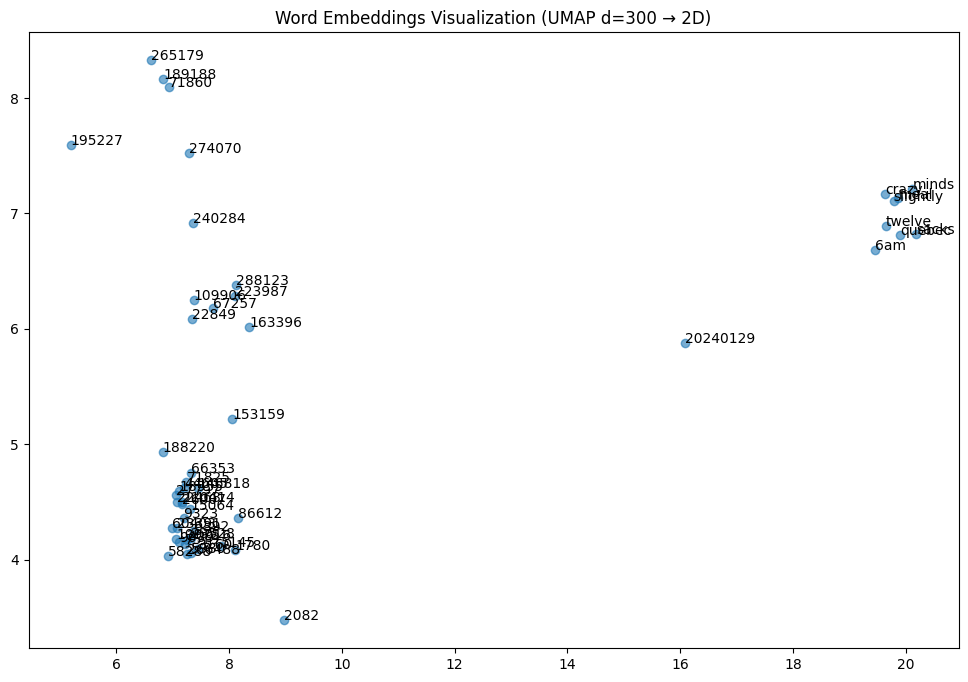

In [ ]:
import random
import matplotlib.pyplot as plt

# Select a sample of words for visualization
sample_size = 50
sample_indices = random.sample(range(len(word2idx)), sample_size)
sample_words = [list(word2idx.keys())[i] for i in sample_indices]

# Extract UMAP embeddings for sampled words (using best d=300)
sample_embeddings = umap_embeddings[300][sample_indices]

# Plot the embeddings
plt.figure(figsize=(12, 8))
plt.scatter(sample_embeddings[:, 0], sample_embeddings[:, 1], alpha=0.6)

# Annotate words
for i, word in enumerate(sample_words):
    plt.annotate(word, (sample_embeddings[i, 0], sample_embeddings[i, 1]), fontsize=10)

plt.title("Word Embeddings Visualization (UMAP d=300 → 2D)")
plt.show()

This shows us that SVD method is a better method as compared to umap for this dataset

# **Comparing with Pre-Trained Neural Embedding**

**We will use Word2Vec and GloVe**

In [20]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 22.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [21]:
import gensim.downloader as api

print("🔹 Downloading Word2Vec (Google News) model...")
word2vec_model = api.load("word2vec-google-news-300")
print("✅ Word2Vec model loaded!")

🔹 Downloading Word2Vec (Google News) model...
[==================================================] 100.0% 1662.8/1662.8MB downloaded
✅ Word2Vec model loaded!


In [22]:
#Loading GloVe
import gensim

# Download & load GloVe (Wikipedia + Gigaword)
print("🔹 Downloading GloVe (Wikipedia+Gigaword) embeddings...")
glove_model = api.load("glove-wiki-gigaword-300")
print("✅ GloVe model loaded!")

🔹 Downloading GloVe (Wikipedia+Gigaword) embeddings...
[==================================================] 100.0% 376.1/376.1MB downloaded
✅ GloVe model loaded!


In [23]:
def get_pretrained_vector(word, model):
  if word in model:
    return model[word]
  return None

In [26]:
from scipy.spatial.distance import cosine

In [27]:
def compare_pretrained_similarity(word1,word2):
  print(f"\n Similarity between '{word1}' and '{word2}':")

  for name, model in [("Word2Vec", word2vec_model), ("GloVe", glove_model)]:
    vec1 = get_pretrained_vector(word1, model)
    vec2 = get_pretrained_vector(word2, model)

    if vec1 is None or vec2 is None:
      print(f"'{word1}' or '{word2}' not found in pretrained model '{name}'")
      continue
    similarity = 1 - cosine(vec1, vec2)
    print(f"{name}: Cosine Similarity = {similarity:.4f}")

In [28]:
compare_pretrained_similarity("king", "queen")
compare_pretrained_similarity("car", "engine")


 Similarity between 'king' and 'queen':
Word2Vec: Cosine Similarity = 0.6511
GloVe: Cosine Similarity = 0.6336

 Similarity between 'car' and 'engine':
Word2Vec: Cosine Similarity = 0.4080
GloVe: Cosine Similarity = 0.4842


We will visualise embeddings

In [35]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [32]:
sample_words = ["king", "queen", "apple", "banana", "car", "truck", "dog", "cat", "france", "italy", "guitar", "piano"]

In [36]:
def visualise_pretrained_embeddings(model, model_name):
  vectors=[]
  valid_words=[]

  for word in sample_words:
    vec=get_pretrained_vector(word, model)
    if vec is not None:
      vectors.append(vec)
      valid_words.append(word)
  vectors=np.array(vectors)

  pca=PCA(n_components=2)
  reduced=pca.fit_transform(vectors)

  plt.figure(figsize=(10,6))
  plt.scatter(reduced[:,0],reduced[:,1],alpha=0.7)

  for i, word in enumerate(valid_words):
    plt.annotate(word, (reduced[i, 0], reduced[i, 1]), fontsize=10)

  plt.title(f"Word Embeddings Visualization (Pretrained {model_name})")
  plt.show()

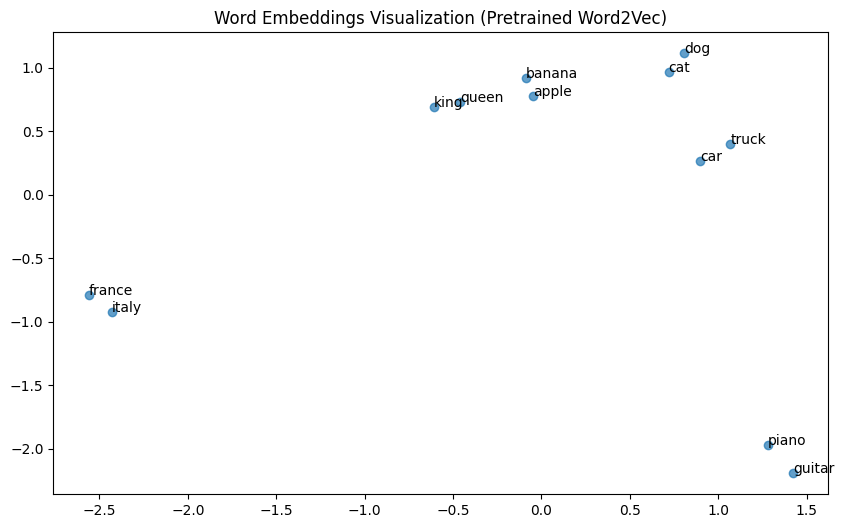

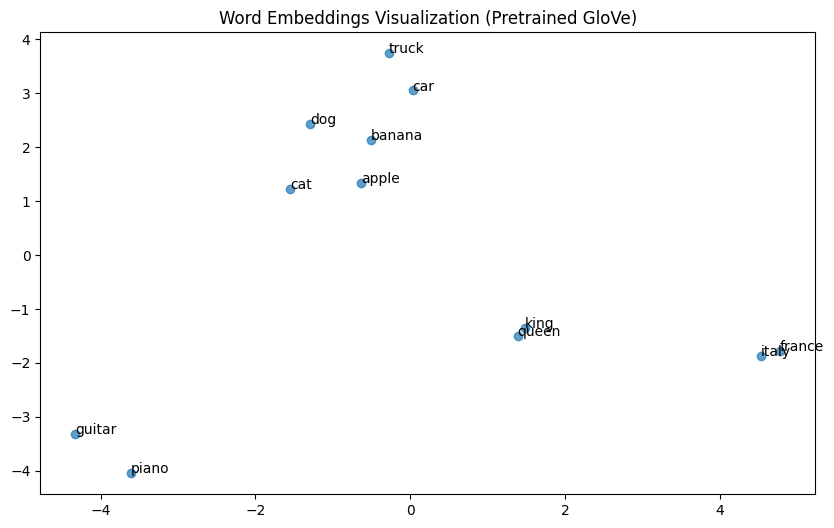

In [37]:
visualise_pretrained_embeddings(word2vec_model, "Word2Vec")
visualise_pretrained_embeddings(glove_model, "GloVe")

*From cosine similarity, we are able to find that our model has better correlation as compared to both the Traditional models*